## 필수 라이브러리 호출

In [1]:
import os
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import re
from pyspark.sql.functions import col, to_timestamp
import pymysql
import mysql.connector
import kss
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from konlpy.tag import Okt, Mecab
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Kkma
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pyspark.sql.functions import col, to_timestamp
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, pipeline, TextClassificationPipeline
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
from soynlp.normalizer import repeat_normalize

## 폰트 설정

In [2]:
font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['/usr/share/fonts/truetype/noto/NotoSerifKhmer-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansLepcha-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansGurmukhi-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifBengali-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifSinhala-Bold.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansTaiLe-Regular.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansDisplay-Italic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansBrahmi-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansOriya-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSerifLao-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansLao-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansArmenian-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansSamaritan-Regular.ttf',
 '/usr/share/fonts/truetype/noto/NotoSansRunic-Regular.ttf',
 '/usr/share/

In [3]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## MySQL에서 데이터 불러오기

In [2]:
host_ip = "15.168.221.131"  
DATABASE = "SNS_DB"
user_id = "lab13"
user_password = "lab13"
mysql_url = f"jdbc:mysql://{host_ip}:3306/{DATABASE}"

In [3]:
connection = mysql.connector.connect(
    host='localhost',
    user='lab13',
    password='lab13',
    database='SNS_DB',
    charset='utf8mb4'
)

cursor = connection.cursor()
cursor.execute("SHOW TABLES;")  
for table in cursor.fetchall():
    print(table[0])

analysis_results
analysis_stopword
auth_group
auth_group_permissions
auth_permission
auth_user
auth_user_groups
auth_user_user_permissions
django_admin_log
django_content_type
django_migrations
django_plotly_dash_dashapp
django_plotly_dash_statelessapp
django_session
hobby_keywords
hobby_trends
phone_recommendations
tbCrawled_Danawa
tbCrawled_Youtube
tbProcessed_Youtube
users


In [4]:
table_name = "tbCrawled_Youtube"
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;") 
rows = cursor.fetchall()
for row in rows:
    print(row)

(29000, 'JEnFUkGHN5E', '애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!', datetime.date(2025, 1, 25), 'ITSub잇섭', '중간에 S25 티타늄 그레이 컬러를 24로 잘못들어서 실물 색상은\n04:21 참고해주세요!', 596, datetime.date(2025, 1, 25), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29001, 'JEnFUkGHN5E', '애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!', datetime.date(2025, 1, 25), 'ITSub잇섭', '울트라는뭐,, 매년상승되는 기본상승력인 스냅말고없음,, 가격내렷어야함 16기가가 기본이던가', 0, datetime.date(2025, 2, 19), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29002, 'JEnFUkGHN5E', '애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!', datetime.date(2025, 1, 25), 'ITSub잇섭', '25플러스 도 쓸만함?', 1, datetime.date(2025, 2, 18), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29003, 'JEnFUkGHN5E', '애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!', datetime.date(2025, 1, 25), 'ITSub잇섭', '2배아니고2세대 ㅎㅎ\n기본 플러스도 디자인만이라도통일시켜주지', 0, datetime.date(2025, 2, 18), datetime.datetime(2025, 2, 27, 20, 59, 54))
(29004, 'JEnFUkGHN5E', '애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!', datetime.date(2025, 1, 25), 'ITSub잇섭', 

In [5]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
count = cursor.fetchone()[0]
count

145718

In [6]:
cursor.execute(f"SELECT * FROM {table_name};")
data = cursor.fetchall()
df = pd.DataFrame(data, columns=['index', 'video_id', 'title', 'publish_date', 'channel_name', 'comment', 'like_count', 'comment_publish_date', 'load_date'])

df = df.drop(columns=[df.columns[0]])
df.head(10)

,video_id,title,publish_date,channel_name,comment,like_count,comment_publish_date,load_date
0,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,중간에 S25 티타늄 그레이 컬러를 24로 잘못들어서 실물 색상은\n04:21 참고해주세요!,596,2025-01-25,2025-02-27 20:59:54
1,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,"울트라는뭐,, 매년상승되는 기본상승력인 스냅말고없음,, 가격내렷어야함 16기가가 기본이던가",0,2025-02-19,2025-02-27 20:59:54
2,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,25플러스 도 쓸만함?,1,2025-02-18,2025-02-27 20:59:54
3,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,2배아니고2세대 ㅎㅎ\n기본 플러스도 디자인만이라도통일시켜주지,0,2025-02-18,2025-02-27 20:59:54
4,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,"😂앱등이들아 애플의 온실왕국에서 \n밖의 갤럭시들판으로 나와😂\n\n춥고, 비내리고, 눈 내리고 안전한애플왕국보다 위험할수도 있어..😢.\n\n하지만...애플왕국 밖에는\n신기하고 경이로운것들이 많고,\n무엇보다도 어마어마한 자유😊를 누릴수있어😊\n\n폐쇄적인 애플생태계를 벗어나야\n신세계를 경험할수있는거야😊",0,2025-02-17,2025-02-27 20:59:54
5,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,인트로 대충찍은거 딱 걸렸죠,0,2025-02-17,2025-02-27 20:59:54
6,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,12:50 드디어 이런시대가\n\nhttps://youtu.be/zlJtohZSsfY,0,2025-02-15,2025-02-27 20:59:54
7,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,혀가 짧니 트랙터시동소리😂😂😂,0,2025-02-15,2025-02-27 20:59:54
8,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,아니 빅스비에서 되던건 되게 해줘야지요. 저는 알람이나 타이머 음성으로 맞추는거 제일 많이 쓰는데 그게 안됩니다. ㅠ.ㅠ,0,2025-02-15,2025-02-27 20:59:54
9,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,3:10 이딴 기능이 없어져서....ㅠ,1,2025-02-13,2025-02-27 20:59:54


In [7]:
df.shape

(145718, 8)

In [9]:
df.duplicated().sum()

18395

## 1차 전처리
1. 중복 제거 
2. 영어랑 공백만 있는 댓글 제거

In [8]:
def clean_data(df):
    # 중복 제거
    df = df.drop_duplicates()

    # 영어와 공백만 있는 댓글 제거
    df = df[~df["comment"].astype(str).str.fullmatch(r"[a-zA-Z\s]+")]

    # 빈 문자열 혹은 공백만 있는 댓글 제거
    df = df[df["comment"].astype(str).str.strip() != '']

    return df

df_tmp =clean_data(df)
df_tmp.shape

(127150, 8)

In [10]:
df_tmp = df.copy()

In [11]:
df_tmp.comment.head(50)

0                                                                                                                                                                                                                                                                                                                                                             중간에 S25 티타늄 그레이 컬러를 24로 잘못들어서 실물 색상은\n04:21 참고해주세요!
1                                                                                                                                                                                                                                                                                                                                                              울트라는뭐,, 매년상승되는 기본상승력인 스냅말고없음,, 가격내렷어야함 16기가가 기본이던가
2                                                                                                                                                                                                   

## 텍스트 정제

In [ ]:
stopwords = {
    "근데", "진짜", "진쨔", "진짜루", "진짜로", "진쨔루"
}

# 텍스트 정제
def clean(text): 
    # 시간 패턴 제거 (예: "12:30" 같은 시간 표현)
    time_pattern = re.compile(r'\b\d{1,2}:\d{2}\b')
    text = time_pattern.sub('', text)
    
    # 특수 문자, 이모지 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)
    
    # URL 제거
    url_pattern = re.compile(r'(https?://|www\.)\S+|https\S+|http\S+', re.IGNORECASE)
    text = url_pattern.sub('', text)
    
    # 불필요한 공백 제거
    text = text.strip()
    
    # 자음만 반복되는 경우 제거 (예: ㅋㅋㅋ, ㅎㅎㅎ)
    text = re.sub(r'([ㄱ-ㅎ])\1+', '', text)
    
    # 모음만 반복되는 경우 제거 (예: ㅜㅜㅜ, ㅠㅠㅠ)
    text = re.sub(r'([ㅏ-ㅣ])\1+', '', text)

    # 불용어 제거 (단어 단위로 정확히 제거)
    words = re.findall(r'\b\w+\b', text)  # 단어 단위로 추출
    text = ' '.join([word for word in words if word not in stopwords])

    return text


# 정규화 (브랜드 기종 합치기)
def normalize(text):
    
    # 소문자로 변환
    text = text.lower()
    
    # 삼성 모델 패턴 일반화
    samsung_patterns = [
    r"s\d+\+?",                 # s24, s25+
    r"갤럭시s\d+",              # 갤럭시s24
    r"갤\d+",                   # 갤24
    r"\d+플러스",               # 24플러스
    r"\d+울트라",               # 25울트라
    r"갤\d+울트라",             # 갤25울트라
    r"울트라",                  # 울트라
    r"삼성폰",                  # 삼성폰
    r"갤럭시폰",                # 갤럭시폰
    r"fe",                      # fe
    r"\d+플립",                 # 5플립, 4플립
    r"갤\d+플립",               # 갤5플립
    r"플립",                    # 플립
    r"노트\d+",                 # 노트10, 노트20
    r"갤노트\d+",               # 갤노트10
    r"노트",                    # 노트
    r"\d+폴드",                 # 5폴드, 4폴드
    r"갤\d+폴드",               # 갤5폴드
    r"폴드",                    # 폴드
    r"z폴드"                    # z폴드
]
    
    # 아이폰 모델 패턴 일반화
    iphone_patterns = [
    r"\d{2}pro(max)?",          # 16pro, 16promax
    r"\d{2}프맥",               # 16프맥
    r"프맥\d{2}",               # 프맥15
    r"프맥",                    # 프맥
    r"아이폰\d+",               # 아이폰16
    r"미니",                    # 미니
    r"se",                      # se
    r"pro(max)?",               # pro, promax
    r"프로맥스",                # 프로맥스
    r"프로",                    # 프로
    r"맥스",                     # 맥스
    r"아이폰프로맥스"            # 아이폰프로맥스
]
    
    # 단어가 앞에 나오면 변환 (조사 여부와 관계없이 적용)
    for pattern in samsung_patterns:
        text = re.sub(fr"\b{pattern}", "갤럭시", text)

    for pattern in iphone_patterns:
        text = re.sub(fr"\b{pattern}", "아이폰", text)

    # 불필요한 공백 제거
    text = re.sub(r"\s+", " ", text).strip()
    
    text = text.replace('갤럭시+', '갤럭시')

    return text

# 문장 분리
def split_sentences(text):
    return kss.split_sentences(text)

df_tmp["cleaned_comment"] = df_tmp["comment"].apply(clean)  
print(df_tmp.shape)
df_tmp["normalized_comment"] = df_tmp["cleaned_comment"].apply(normalize)  
print(df_tmp.shape)
df_tmp['split_sentences'] = df_tmp['normalized_comment'].apply(split_sentences)
df_split = df_tmp.explode("split_sentences").reset_index(drop=True)
df_split = df_split.rename(columns={"split_sentences": "sentence"})
print(df_split.shape)

(145718, 9)


[Kss]: Oh! You have konlpy.tag.Mecab in your environment. Kss will take this as a backend! :D



(145718, 10)


In [ ]:
df_tmp['cleaned_comment'].head()

In [16]:
df_split.sentence.head(30)

0                                                                                                          중간에 갤럭시 티타늄 그레이 컬러를 24로 잘못들어서 실물 색상은 참고해주세요
1                                                                                                                           갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음
2                                                                                                                                              가격내렷어야함
3                                                                                                                                          16기가가 기본이던가
4                                                                                                                                            갤럭시 도 쓸만함
5                                                                                                                       2배아니고2세대 기본 플러스도 디자인만이라도통일시켜주지
6     앱등이들아 애플의 온실왕국에서 밖의 갤럭시들판으로 나와 춥고 비내리고 눈 내리고 안전한애플왕국보다 위험할수도 있어 하지만애플왕국 밖에는 신기하고 경이로운것들이

In [84]:
# 키워드 테스트
k = ["ip68"]

def has_brand_keyword(comment):
    return any(keyword in comment for keyword in k)

# 특정 키워드를 포함하는 행만 필터링
filtered_sentences = df_split[df_split['sentence'].apply(has_brand_keyword)]

# 결과
print(filtered_sentences.sentence.count())
for sentence in filtered_sentences['sentence']:
    print(sentence)

2
샤오미 13 시리즈부터 파생형 제외하고 전원 ip68 방수방진 지원한다고 하구요
샤오미 13 시리즈부터 파생형 제외하고 전원 ip68 방수방진 지원한다고 하구요


In [18]:
# 브랜드별 키워드 설정
apple_keywords = [
    "ios", "m1", "m2", "애플 실리콘",  # 운영체제 & 칩셋
    "페이스 id", "faceid", "페이스 아이디", "페이스아이디", "트루뎁스",  # 보안 & 생체인식
    "icloud", "아이클라우드", "에어드롭", "에어드랍",  # 클라우드 & 공유 기능
    "맥세이프", "magsafe", "다이나믹 아일랜드",  # 디스플레이 & 디자인
    "애플페이", "애플 페이", "애플 월렛",  # 결제 & 서비스
    "시리", "siri", "뉴럴 엔진",  # 음성 & AI
    "애플케어",  # 보증 & 지원
    "애플 뮤직",  # 음악 & 미디어
    "라이트닝"  # 기타
]

samsung_keywords = [
    "안드로이드", "엑시노스", "액시노스", "스냅드래곤",  # 운영체제 & 칩셋
    "초음파",  # 보안 & 생체인식
    "아몰레드", "amoled", "고릴라 글래스", "폴더블", "폴더블폰",  # 디스플레이 & 디자인
    "s펜", "spen", "s pen",  # 입력 도구
    "삼성 페이", "삼페", "삼성페이", "삼성 월렛",  # 결제 & 서비스
    "빅스비",  # 음성 & AI
    "삼성 헬스",  # 건강 & 웨어러블
    "방수방진", "빅터스",  # 보안 & 내구성
    "dex",  # 생산성 & 확장성
    "굿락", "good lock",  # 커스터마이징 & 편의 기능
    "s시리즈", "갤럭시", "겔럭시", "삼성"  # 기타
]

def has_brand_keyword(comment):
    samsung_count = sum(comment.count(keyword) for keyword in samsung_keywords)
    apple_count = sum(comment.count(keyword) for keyword in apple_keywords)
    
    # 삼성이랑 애플 관련 키워드가 하나도 포함되지 않으면 제거
    return samsung_count > 0 or apple_count > 0

df_split = df_split[df_split["sentence"].apply(has_brand_keyword)].reset_index(drop=True)
df_split.shape

(42072, 11)

In [26]:
df_split.sentence.tail(50)

42022                                                                                                                                     핸폰이 넘 비쌈 갤럭시북도 200만원대인데
42023                                                                                                                                              현재 갤럭시를 사용중입니다
42024                                                 우선 갤럭시도 120헤르츠를 지원하다보니 저전력모드를 켜서 60으로 쓰니까 역체감이 좀 크기도 했고 제가 주로 풍경사진을 찍기 좋아하는데 5배줌을 쓰는 사진의 비율이 6안씀4씀정도가 되더라구요
42025                                                                                               11프로 사용자인데 120의 주사율을 느껴본 적이 없어서 굳이 16프로 대신 일반 16이나 갤럭시로 갈까합니다
42026                                                                                                                                       차량 맥세이프 거치대 정보 알수있을까용
42027                                                                              솔직히 이번에 워치 갤럭시 3 안나오고 블랙 색상만 나오고 에어팟 아이폰도 색만 바꾼거보고 이새끼들 일 안하고 돈벌려고 하네 싶은 생각 싹듬
42028                       

In [18]:
# df_sample = df_split[['sentence']].sample(n=500, random_state=42)
# df_sample.to_csv('labeling_data.csv', index=False)

In [24]:
df_sample_labeled = pd.read_csv('labeled_data.csv')
df_sample_labeled.head()

,sentence,brand,sentiment
0,갤럭시는 두께가 5cm,none,NaN
1,12시리즈때 폰 바꾸면서 사고 이번에 16프로로 바꾸면서 구매할려고 하는데 벌써 품절이네요,none,NaN
2,엑시노스에 대한 리스크가 조금 있기는 하지만 믿고 가보려고 합니다,samsung,positive
3,지금은 갤럭시인데 애플워치맥북 아이패드 에어팟을 가지고있는쿠,none,NaN
4,왤케 갤럭시는꺼는 고장도 잘나고 돈주고 사기에는 아까운 저급한 품질이라,samsung,negative


In [25]:
df_sample_labeled.brand.value_counts()

brand
samsung    322
none       130
apple       48
Name: count, dtype: int64

In [61]:
df_sample_labeled.brand.value_counts(normalize=True)

brand
samsung    0.644
none       0.260
apple      0.096
Name: proportion, dtype: float64

In [21]:
df_sample_labeled.sentiment.value_counts()

sentiment
positive    166
negative    147
neutral      57
Name: count, dtype: int64

In [22]:
df_sample_labeled[['brand', 'sentiment']].value_counts()

brand    sentiment
samsung  positive     149
         negative     123
         neutral       50
apple    negative      24
         positive      17
         neutral        7
Name: count, dtype: int64

## kcelectra
- df_sample_labeled에서 라벨링된 데이터(500개)를 사용해 모델 학습
- 학습 모델로 df_split의 문장에 대해 브랜드 예측
- df_split에 브랜드 추가

In [27]:
# 오버샘플링
from sklearn.utils import resample

# 'apple'과 'none' 클래스 오버샘플링
apple_samples = df_sample_labeled[df_sample_labeled['brand'] == 'apple']
none_samples = df_sample_labeled[df_sample_labeled['brand'] == 'none']

# 오버샘플링
apple_upsampled = resample(apple_samples, replace=True, n_samples=322, random_state=42)  # 삼성과 같은 샘플 수로 맞추기
none_upsampled = resample(none_samples, replace=True, n_samples=322, random_state=42)

# 합치기
df_sample_balanced = pd.concat([df_sample_labeled[df_sample_labeled['brand'] == 'samsung'], apple_upsampled, none_upsampled])
print(df_sample_balanced['brand'].value_counts())

brand
samsung    322
apple      322
none       322
Name: count, dtype: int64


In [36]:
# 기존 모델 삭제 & 메모리 정리
import torch
import gc

del model
gc.collect()
torch.cuda.empty_cache()

In [37]:
model_name = 'beomi/KcELECTRA-base-v2022'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class BrandDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_map = {"samsung": 0, "apple": 1, "none": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["sentence"]
        label = self.label_map[self.data.iloc[idx]["brand"]]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# 데이터셋 로드
dataset = BrandDataset(df_sample_balanced, tokenizer)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[ WARNING ]: 00:03:39 | Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[ WARNING ]: 00:03:39 | Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


[ WARNING ]: 00:03:41 | Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
[ WARNING ]: 00:03:41 | Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


In [38]:
from transformers import AdamW
from torch.nn import functional as F

# 클래스 가중치
# class_weights = torch.tensor([1.5, 1.5, 1]).to(device) 

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 루프
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
#         weight = class_weights[labels]  # 각 배치에 대한 가중치
#         loss = (loss * weight).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 0.7816892866014449
Epoch 2, Loss: 0.27533784507165765
Epoch 3, Loss: 0.152838558405022
Epoch 4, Loss: 0.08842874032422161
Epoch 5, Loss: 0.016056115550473947


In [39]:
# # 모델 저장
# torch.save(model.state_dict(), 'brand_classification_model.pth')
# print('모델 가중치 저장완료')

모델 가중치 저장완료


In [40]:
def predict_brand(text):
    model.eval()
    encoding = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()

    label_map = {0: "samsung", 1: "apple", 2: "none"}
    return label_map[prediction]

# 예시 문장
test_sentence = "갤럭시 성능이 뛰어나"
print(predict_brand(test_sentence))  # "samsung"

df_split['predicted_brand'] = df_split['sentence'].apply(predict_brand)

samsung


In [ ]:
# # 모델 불러오기
# # 동일한 모델 구조 선언
# model_name = 'beomi/KcELECTRA-base-v2022'
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# # 가중치 로드
# model.load_state_dict(torch.load("brand_classification.pth"))

# # GPU/CPU 할당
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # 모델을 평가 모드로 변경
# model.eval()

# print("모델 가중치 로드 완료")

In [41]:
df_split['predicted_brand'].value_counts()

predicted_brand
samsung    32964
none        6682
apple       2426
Name: count, dtype: int64

In [42]:
df_split[df_split['predicted_brand']=='apple'][['sentence']]

,sentence
50,아이폰은 애플케어플러스 가입해서 생폰 갖고 다니는데 삼성은 어떤가요
52,지금 구글 픽셀 8을 사용중인데 솔직히 삼성 ai 픽셀8이랑 너무 비슷함 구동시간도 비슷한거 같은데 구글픽셀 8pro는 온디바이스로 ai구동이 엄청빠르지 않나 삼성은 너무 느린데
70,생산 공정 단순화를 해서 액정도 프레임도 만들기 편하니 아이폰 아이폰까지가 딱 그립감 최고였는데 그후론 점점 각지더니 15프로 쥐어보니 그립감 망 삼성도 점점 각져지더니 이젠 그냥 도시락이네요
118,삼성매장에서 제가 지금 사용하는 아이폰 14프로와 갤럭시 갤럭시를 극단적으로 핸드폰 흔들면서 찍어서 비교해보면 여전히 갤럭시만 사진 영상x은 번져서 나옵니다
126,아이폰을 사용중인데 삼성페이와 큰 화면 베터리 등의 편의성때문에 갤럭시 갤럭시로 넘어갈지 아니면 아이폰 15프로로 넘어갈지 고민중입니다
...,...
42049,16을 사야할까 요약하자면 15시리즈 쓰던 사람 굳이 15시리드 이전 쓰던 사람 c타입이 아니기 때문에 넘어와도 좋다 13프로 쓰다가 16프로 넘어왔는데 c타입 하나로 너무 만족중 이제 패드랑 맥북 들고 다닐때 아이폰만 찐따처럼 라이트닝 따로 들고다닐 필요 없어서 넘 좋음
42051,16사면 루저에요 카메라 컨트롤 버튼 엄청 불편하고 고스트현상 15시리즈랑 차이 1도없음
42058,아이폰 3 때 부터 지금 아이폰 까지 애플 생태계 속에 살고 있는데 이제는 안드로이드로 갈 때가 되었구나
42064,4년 쓸 작정으로 16갈아타는데 갤럭시하고 16하고 크기차이 심한가요 손이 작은편이고 지금 12일반 쓰고있는데 배터리용량땜시 플러스가 끌리네요


In [43]:
df_split[df_split['predicted_brand']=='none'][['sentence']]

,sentence
0,중간에 갤럭시 티타늄 그레이 컬러를 24로 잘못들어서 실물 색상은 참고해주세요
3,앱등이들아 애플의 온실왕국에서 밖의 갤럭시들판으로 나와 춥고 비내리고 눈 내리고 안전한애플왕국보다 위험할수도 있어 하지만애플왕국 밖에는 신기하고 경이로운것들이 많고 무엇보다도 어마어마한 자유를 누릴수있어 폐쇄적인 애플생태계를 벗어나야 신세계를 경험할수있는거야
17,애플 3gs 나올때 삼성 옴니아 나왔을때 기억이나네 삼성 많이 애플 따라 갔네
34,잇섭님 요즘 갤럭시 일반 모델에 플리커링 얘기가 나오고 있는 것 같은데 테스트 한번만 부탁드리겠습니다
43,갤럭시라고
...,...
42041,입으신 체크셔츠랑 맥세이프 차량용 충전기 정보 궁금합니다
42047,쓰시고 계시는 맥세이프 스마트링 정보가 궁금합니다
42048,지하님 그 벨킨 맥세이프링 쓰면 편한가요 손가락 아프다는 사람들도 있길래
42060,ios18은 언제나오나영


In [44]:
df_split[df_split['predicted_brand']=='samsung'][['sentence']]

,sentence
1,갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음
2,갤럭시 도 쓸만함
4,아니 빅스비에서 되던건 되게 해줘야지요
5,전 겔럭시 갤럭시 갤럭시 유저인데 갤럭시울트라는 반도체와 각종 부품을 중국산을 쓰니 쌰오미와 비슷해진듯 우리의 삼성 어디
6,이젠 갤럭시이 아이폰보다 더 예뻐보인다
...,...
42065,티타늄 애플워치 살빠에 차리리 내년에 갤럭시3 사는게 나을듯한데 가격차이가 별로 없어서
42066,아 ios18는 탐나는데 지금 쓰는 5배줌이 너무 좋고 색은 또 일반16이 예쁘고 그냥 갤럭시로 갈아탈까
42068,갤럭시마린 아쉽다 카메라부분만 찐 갤럭시마린 색이고 본체는 물빠진 색이넹
42070,저도 이젠삼성 으로 갈아타야


## 감성분석 모델링

In [45]:
# # 삼성 데이터 필터링
# df_samsung = df_split[df_split['predicted_brand'] == 'samsung']
# df_samsung.to_csv('samsung_df.csv', index=False)

# # 애플 데이터 필터링
# df_apple = df_split[df_split['predicted_brand'] == 'apple']
# df_apple.to_csv('apple_df.csv', index=False)

In [4]:
df_apple = pd.read_csv('samsung_df.csv')
df_samsung = pd.read_csv('apple_df.csv')
df_apple.shape, df_samsung.shape

((32964, 12), (2426, 12))

In [46]:
# 감성 분석 모델 로드
tokenizer = AutoTokenizer.from_pretrained("Copycats/koelectra-base-v3-generalized-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("Copycats/koelectra-base-v3-generalized-sentiment-analysis")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer, model=model, device=device)

# 삼성 데이터 필터링
df_samsung = pd.read_csv('samsung_df.csv')

# 애플 데이터 필터링
df_apple = pd.read_csv('apple_df.csv')

# 배치
def process_batch(reviews):
    return sentiment_classifier(reviews)

# 삼성 감성 분석 (배치로 처리)
samsung_reviews = df_samsung['sentence'].tolist()
samsung_predictions = process_batch(samsung_reviews)

df_samsung['samsung_sentiment'] = [pred['label'] for pred in samsung_predictions]
df_samsung['samsung_score'] = [pred['score'] for pred in samsung_predictions]

# 애플 감성 분석 (배치로 처리)
apple_reviews = df_apple['sentence'].tolist()
apple_predictions = process_batch(apple_reviews)

df_apple['apple_sentiment'] = [pred['label'] for pred in apple_predictions]
df_apple['apple_score'] = [pred['score'] for pred in apple_predictions]

In [47]:
df_apple[['sentence','apple_sentiment', 'apple_score']].head(10)

,sentence,apple_sentiment,apple_score
0,아이폰은 애플케어플러스 가입해서 생폰 갖고 다니는데 삼성은 어떤가요,0,0.666781
1,지금 구글 픽셀 8을 사용중인데 솔직히 삼성 ai 픽셀8이랑 너무 비슷함 구동시간도 비슷한거 같은데 구글픽셀 8pro는 온디바이스로 ai구동이 엄청빠르지 않나 삼성은 너무 느린데,1,0.608246
2,생산 공정 단순화를 해서 액정도 프레임도 만들기 편하니 아이폰 아이폰까지가 딱 그립감 최고였는데 그후론 점점 각지더니 15프로 쥐어보니 그립감 망 삼성도 점점 각져지더니 이젠 그냥 도시락이네요,0,0.958305
3,삼성매장에서 제가 지금 사용하는 아이폰 14프로와 갤럭시 갤럭시를 극단적으로 핸드폰 흔들면서 찍어서 비교해보면 여전히 갤럭시만 사진 영상x은 번져서 나옵니다,0,0.924160
4,아이폰을 사용중인데 삼성페이와 큰 화면 베터리 등의 편의성때문에 갤럭시 갤럭시로 넘어갈지 아니면 아이폰 15프로로 넘어갈지 고민중입니다,0,0.865027
5,과거 시리즈에서는 기본형인 s모델은 후면 소재가 플라스틱으로 이루어져 있었는데 이번 24 모델은 기본형인 s와 플러스 모델의 후면 소재가 플라스틱인지 유리인지 알 수 있을까요,1,0.682519
6,갤럭시시리즈 폰케이스 만드실 계획은 없으신가요 아이폰프로 아톰케이스 쓰고있는데 퀄리티에 감탄했습니다,1,0.976547
7,새로운 aod는 23시리즈에는 탑재가 안 되나요,1,0.815846
8,그런데 신기한 건 같은 amoled를 쓰는 아이폰은 눈이 시리다거나 눈이 쉽게 피로해진다거나 하는 게 전혀 없더라고요,1,0.720088
9,제미나이 음성이 미쳣는데요 사람 같음 빅스비는 그냥 말투 자체가 그냥 딱 아이폰그램 ai 음성 느낌인데 제미나이 음성은 아나운서나 나레이션 목소리라서 옆에서 틀어놓으면 사람인 줄 착각할듯,0,0.817673


In [48]:
df_samsung[['sentence','samsung_sentiment', 'samsung_score']].head(10)

,sentence,samsung_sentiment,samsung_score
0,갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음,0,0.978018
1,갤럭시 도 쓸만함,1,0.929495
2,아니 빅스비에서 되던건 되게 해줘야지요,0,0.863897
3,전 겔럭시 갤럭시 갤럭시 유저인데 갤럭시울트라는 반도체와 각종 부품을 중국산을 쓰니 쌰오미와 비슷해진듯 우리의 삼성 어디,0,0.786425
4,이젠 갤럭시이 아이폰보다 더 예뻐보인다,1,0.955561
5,애플도 최근에 바이트애플 마크 없애는 추세라 디자인 차이도 별로 안 나고 갤럭시 예전이랑 비교하면 이미지나 디자인 정말 잘 바뀐 듯,0,0.927334
6,재미나이 저런 앱과의 상호작용은 일반 갤럭시는 안돼나요,1,0.739744
7,전작들은 샤오미 고급 폰 같았는데 갤럭시 부터는 애플 폰 옆에 갖다놔도 짜친다는 느낌이 없음,1,0.937219
8,갤럭시는 짝수 라임으로 갈아타는게 좋은것같아요,0,0.764192
9,갤럭시 갤럭시 쓰고 있는데 요즘 폰이 고장나서 바꿀 계획중인데 아이폰 쓸지 갤럭시울트라 쓸지 고민이네요,0,0.789276


In [49]:
# 브랜드분류, 감성분석 된 최종 파일 저장
# df_samsung.to_csv('final_samsung_df.csv', index=False)
# df_apple.to_csv('final_apple_df.csv', index=False)

## LLM 호출

In [5]:
from get_llm_keyword_list import check_hobby

hobby_id, keyword_list = check_hobby('사진 촬영', 'M', '20s')
keyword_list

['배터리', '사이즈', '화질', '용량', '초점']

## 영상 제목 분석

In [45]:
from pprint import pprint

df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

# 긍정
positive_titles_df = df_samsung[df_samsung['samsung_sentiment'] == 1][['title', 'date_group', 'samsung_sentiment']]

# 부정
negative_titles_df = df_samsung[df_samsung['samsung_sentiment'] == 0][['title', 'date_group', 'samsung_sentiment']]

positive_titles_list = positive_titles_df['title'].unique().tolist()
negative_titles_list = negative_titles_df['title'].unique().tolist()

print("긍정 제목 리스트")
pprint(positive_titles_list)

print("\n부정 제목 리스트")
pprint(negative_titles_list)

긍정 제목 리스트
['애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!',
 '새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.',
 '갤럭시 S24+ VS 갤럭시 S24 울트라 둘 중 무엇을 사야할까 고민된다면?',
 '아이폰에서 4달만에 갈아탄 삼성 갤럭시 S25 울트라 2주 사용기!',
 '진짜 솔직하게요? 두달 내내 매일 써본 삼성 갤럭시 S24 울트라 사용기',
 '아이폰16 프로 언박싱+카메라 버튼 추가+15프로와 화질차이📱iPhone 16 Pro Unboxing #shorts',
 '아이패드 미니 7세대로 더욱 유력하다? 미친 애플 아이폰 SE 4세대 루머 총정리',
 '아이폰 16 발표회... 재미 점수 4.0 / 10',
 '한 달 꽉채워서 써본 갤럭시 Z 폴드6.. 솔직히 만족하시나요?',
 '빛나는 사성이 되어버린 삼성 케이스 근황',
 '아이폰15년차 갤럭시S25울트라 갈아타봤습니다',
 '살지 말지 고민된다면? 삼성 갤럭시 Z 플립6 달라진 9가지 총 정리!',
 '90만원에 육박하는데 돈값 할까? 갤럭시워치 울트라 짧은 사용기 (+워치7)',
 '울트라 버리고 굳이 다운그레이드(?)한 이유? 삼성 갤럭시 S24 기본형 사용기',
 '결국, 아이폰으로 넘어갔다가 다시 돌아왔습니다. S24울트라 두 달 후기',
 '삼성 진짜 긴장해야 될 듯;; 샤오미 15 언빡싱&amp;간단 사용기!',
 '출시하자마자 곤욕을 치른 갤럭시 S24 3가지 이슈 검증! 과연 해결책이 있을까?',
 '갤럭시 S24 울트라 72시간 후기',
 '벤치&amp;발열&amp;카메라 다 비교했습니다 &quot;갤럭시S24 시리즈 사기 전에 반드시 봐야할 영상 1위&quot;',
 '단통법 폐지 확정! 갤럭시 S25 아이폰 16 공짜로 사세요. 휴대폰 싸게 사는 법! (구매가이드, S24 플립6, 폴드6 공시지원금, '
 '시행 시기 효과)',
 '갤럭시 S24 시리즈 리뷰',
 '갤럭시 S24 언박

In [44]:
positive_title_counts = positive_titles_df['title'].value_counts().reset_index()
positive_title_counts.columns = ['title', '긍정_댓글수']

negative_title_counts = negative_titles_df['title'].value_counts().reset_index()
negative_title_counts.columns = ['title', '부정_댓글수']

print("긍정 댓글 수 상위 제목")
print(positive_title_counts.head())

print("\부정 댓글 수 상위 제목")
print(negative_title_counts.head())

긍정 댓글 수 상위 제목
                                          title  긍정_댓글수
0                     아이폰15년차 갤럭시S25울트라 갈아타봤습니다    1880
1     애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!    1030
2   갤럭시 S24+ VS 갤럭시 S24 울트라 둘 중 무엇을 사야할까 고민된다면?     700
3  울트라 버리고 굳이 다운그레이드(?)한 이유? 삼성 갤럭시 S24 기본형 사용기     645
4      결국, 아이폰으로 넘어갔다가 다시 돌아왔습니다. S24울트라 두 달 후기     645
\부정 댓글 수 상위 제목
                                           title  부정_댓글수
0      애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!    1290
1        삼성 진짜 긴장해야 될 듯;; 샤오미 15 언빡싱&amp;간단 사용기!     920
2  출시하자마자 곤욕을 치른 갤럭시 S24 3가지 이슈 검증! 과연 해결책이 있을까?     806
3    갤럭시 S24+ VS 갤럭시 S24 울트라 둘 중 무엇을 사야할까 고민된다면?     762
4          아이폰에서 4달만에 갈아탄 삼성 갤럭시 S25 울트라 2주 사용기!     720


## 좋아요 개수와 감성 트렌드분석 

In [2]:
df_samsung = pd.read_csv('final_samsung_df.csv')
df_apple = pd.read_csv('final_apple_df.csv')

In [3]:
df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

In [4]:
df_samsung.shape

(32964, 15)

In [7]:
keywords = ['배터리', '사이즈', '화질', '용량', '초점']

# 키워드가 들어간 댓글만 필터링
def find_keyword(sentence):
    for keyword in keywords:
        if keyword in sentence:
            return keyword
    return None

df_samsung['keyword'] = df_samsung['sentence'].apply(find_keyword)

# 키워드가 없는 행은 제외
df_filtered = df_samsung[df_samsung['keyword'].notnull()]

In [8]:
df_filtered.shape

(1207, 16)

In [9]:
df_filtered.columns

Index(['video_id', 'title', 'publish_date', 'channel_name', 'comment',
       'like_count', 'comment_publish_date', 'load_date', 'cleaned_comment',
       'normalized_comment', 'sentence', 'predicted_brand',
       'samsung_sentiment', 'samsung_score', 'date_group', 'keyword'],
      dtype='object')

In [59]:
top_comments = []

# 키워드 순회
for keyword in keywords:
    # 해당 키워드만 필터링
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # 긍정 
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    top_positive = positive_df.sort_values(by='like_count', ascending=False).head(1)
    
    # 부정 
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    top_negative = negative_df.sort_values(by='like_count', ascending=False).head(1)
    
    # 리스트에 추가
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '긍정',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'comment': top_positive.iloc[0]['sentence']
        })
        
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '부정',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'comment': top_negative.iloc[0]['sentence']
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count  \
0     배터리        긍정         274   
1     배터리        부정         127   
2     사이즈        긍정          82   
3     사이즈        부정         125   
4      화질        긍정          26   
5      화질        부정           7   
6      용량        긍정          24   
7      용량        부정         124   
8      초점        긍정          15   
9      초점        부정         497   

                                                                                                                                                                                                  comment  
0                                                                                                                                                      갤럭시3쓰다 갤럭시 기본형으로 넘어온 저는 배터리 너무 길어서 만족 하루종일 써도 안닳아요  
1                                                                                                                                                              아마 갤럭시 폭발 사건 때문에 배터리 기술에 대해서는 아직 보수적인것 같네요  
2 

In [68]:
# 키워드 별로 가장 대표적인 긍정/부정 댓글 뽑기
top_comments = []

# 키워드 순회
for keyword in keywords:
    # 해당 키워드만 필터링
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # 긍정 필터링
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    # score가 높은 순 + like_count 높은 순
    top_positive = positive_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # 부정 필터링
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    # score가 높은 순 + like_count 높은 순
    top_negative = negative_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # 결과 리스트에 추가
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '긍정',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'score': round(top_positive.iloc[0]['samsung_score'], 4),
            'comment': top_positive.iloc[0]['sentence']
        })
        
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '부정',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'score': round(top_negative.iloc[0]['samsung_score'], 4),
            'comment': top_negative.iloc[0]['sentence']
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count   score  \
0     배터리        긍정           0  0.9961   
1     배터리        부정           1  0.9979   
2     사이즈        긍정           4  0.9920   
3     사이즈        부정           0  0.9948   
4      용량        긍정           0  0.9925   
5      용량        부정           0  0.9972   
6      초점        긍정           0  0.8498   
7      초점        부정           2  0.9979   
8      화질        긍정           0  0.9944   
9      화질        부정           0  0.9986   

                                                                                                                                                                                 comment  
0                  아직 폴더블은 안 써봤지만 언젠가 꼭 써보려고 갤럭시4쯤부터 계속 주시하고 있는데 이번 갤럭시6 정도면 정말 완성도가 많이 올라왔다는 생각이 듭니다 특히 카메라랑 배터리 용량이 이제야 정상화되는 느낌이고 디자인은 갤럭시4가 정점일 것 같았는데 6에서 자잘한 변화가 생기면서 훨씬 예뻐진 것 같아요  
1                                  아이폰 사용 해본사람으로서 한마디 하자면 아이폰 디스플레이 번인증상 많고 배터리 졸라 발열 심하고 엄청 불량 많음 왜 중국산 싸구려 배터리 쓰니깐 폰은 개비쌈 as쓰레기고 그래서 갤럭시로 돌아옴 참고중국산배터리

In [69]:
top_comments = []

# 키워드 순회
for keyword in keywords:
    # 해당 키워드만 필터링
    keyword_df = df_filtered[df_filtered['keyword'] == keyword]
    
    # 긍정 필터
    positive_df = keyword_df[keyword_df['samsung_sentiment'] == 1]
    top_positive = positive_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # 부정 필터
    negative_df = keyword_df[keyword_df['samsung_sentiment'] == 0]
    top_negative = negative_df.sort_values(by=['samsung_score', 'like_count'], ascending=[False, False]).head(1)
    
    # 긍정 댓글 추가
    if not top_positive.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '긍정',
            'like_count': int(top_positive.iloc[0]['like_count']),
            'score': round(top_positive.iloc[0]['samsung_score'], 4),
            'sentence': top_positive.iloc[0]['sentence'],
            'comment': top_positive.iloc[0]['comment']
        })
        
    # 부정 댓글 추가
    if not top_negative.empty:
        top_comments.append({
            'keyword': keyword,
            'sentiment': '부정',
            'like_count': int(top_negative.iloc[0]['like_count']),
            'score': round(top_negative.iloc[0]['samsung_score'], 4),
            'sentence': top_negative.iloc[0]['sentence'],
            'comment': top_negative.iloc[0]['comment'] 
        })

top_comments_df = pd.DataFrame(top_comments)
print(top_comments_df)

  keyword sentiment  like_count   score  \
0     배터리        긍정           0  0.9961   
1     배터리        부정           1  0.9979   
2     사이즈        긍정           4  0.9920   
3     사이즈        부정           0  0.9948   
4      용량        긍정           0  0.9925   
5      용량        부정           0  0.9972   
6      초점        긍정           0  0.8498   
7      초점        부정           2  0.9979   
8      화질        긍정           0  0.9944   
9      화질        부정           0  0.9986   

                                                                                                                                                                                sentence  \
0                  아직 폴더블은 안 써봤지만 언젠가 꼭 써보려고 갤럭시4쯤부터 계속 주시하고 있는데 이번 갤럭시6 정도면 정말 완성도가 많이 올라왔다는 생각이 듭니다 특히 카메라랑 배터리 용량이 이제야 정상화되는 느낌이고 디자인은 갤럭시4가 정점일 것 같았는데 6에서 자잘한 변화가 생기면서 훨씬 예뻐진 것 같아요   
1                                  아이폰 사용 해본사람으로서 한마디 하자면 아이폰 디스플레이 번인증상 많고 배터리 졸라 발열 심하고 엄청 불량 많음 왜 중국산 싸구려 배터리 쓰니깐 폰은 개비쌈 as쓰레기고 그래서 갤럭시로 돌아옴 참고중국산배

In [77]:
import openai

api_key = os.environ.get('OPENAI_API_KEY')
client = openai.OpenAI(api_key=api_key)

def simplify_comment(comment):
    prompt = f"""
    아래 문장을 정중하고 이해하기 쉽게 순화해줘. 비속어는 제거하고, 공손한 말투로 다시 작성해줘.
    
    원문: "{comment}"
    
    순화된 문장:
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "당신은 한국어를 잘하는 정중한 문장 교정 전문가입니다."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5,
            max_tokens=150
        )
        
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[에러] 순화 실패: {e}")
        return comment


# 순화된 댓글 추가
top_comments_df['simplified_comment'] = ''

for idx, row in top_comments_df.iterrows():
    original_comment = row['comment']
    simplified = simplify_comment(original_comment)
    
    print(f"\n[{idx + 1}] {row['keyword']} / {row['sentiment']}")
    print(f"원문: {original_comment}")
    print(f"순화: {simplified}")


[1] 배터리 / 긍정
원문: 평소에 갤북, 갤탭, 충전기 3개, 버즈 등등 다 들고 다니는 공대생인데, 디노 백팩처럼 수납이 넉넉하면 학교 다닐 때 정말 편할 것 같아요!
아직 폴더블은 안 써봤지만 언젠가 꼭 써보려고 플립4쯤부터 계속 주시하고 있는데 이번 플립6 정도면 정말 완성도가 많이 올라왔다는 생각이 듭니다.
특히 카메라랑 배터리 용량이 이제야 정상화되는 느낌이고, 디자인은 플립4가 정점일 것 같았는데 6에서 자잘한 변화가 생기면서 훨씬 예뻐진 것 같아요.
항상 갤럭시 리뷰 영상 잘 보고 있습니다!
순화: 평소에 갤럭시 북, 갤럭시 탭, 충전기 3개, 버즈 등을 항상 가지고 다니는 공대생입니다. 그래서 디노 백팩처럼 수납 공간이 넉넉한 가방을 사용하면 학교에 다닐 때 정말 편리할 것 같습니다. 아직 폴더블 기기를 사용해본 적은 없지만, 언젠가 꼭 사용해보고 싶어 플립4부터 계속 관심 있게 지켜보고 있습니다. 이번 플립6은 완성도가 많이 향상된 것 같다는 생각이 듭니다. 특히 카메라와 배터리 용량이 이제야 안정화된 느낌이고, 디자인은 플립4

[2] 배터리 / 부정
원문: 아이폰12,13,15 사용 해본사람으로서 한마디 하자면
아이폰 디스플레이 번인증상 많고,  배터리 졸라 발열 심하고 엄청 불량 많음
 왜? 중국산 싸구려 배터리 쓰니깐 !
근데 폰은 개비쌈 AS쓰레기고  그래서 갤럭시로 돌아옴
참고(중국산배터리중에서도 젤 쓰레기 배터리업체꺼 쓴다고 들었음)단가 줄일려고
순화: 아이폰 12, 13, 15를 사용해 본 사람으로서 말씀드리자면, 아이폰의 디스플레이에서 번인 현상이 자주 발생하고, 배터리 발열이 심하며 불량이 많습니다. 이는 중국산 저렴한 배터리를 사용하기 때문이라고 생각합니다. 그러나 아이폰의 가격은 매우 비싸고, 애프터서비스도 만족스럽지 않아 결국 갤럭시로 바꾸게 되었습니다. 참고로, 중국산 배터리 중에서도 품질이 좋지 않은 업체의 제품을 사용한다고 들었습니다. 이는 비용 절감을 위한 조치로 보입니다.

[3] 사이즈 / 긍정
원문: 내

## 키워드 빈도수 트렌드 분석

In [46]:
import pandas as pd

df_samsung = pd.read_csv('final_samsung_df.csv')
df_apple = pd.read_csv('final_apple_df.csv')

df_samsung.columns

Index(['video_id', 'title', 'publish_date', 'channel_name', 'comment',
       'like_count', 'comment_publish_date', 'load_date', 'cleaned_comment',
       'normalized_comment', 'sentence', 'predicted_brand',
       'samsung_sentiment', 'samsung_score'],
      dtype='object')

In [2]:
df_samsung.head()

,video_id,title,publish_date,channel_name,comment,like_count,comment_publish_date,load_date,cleaned_comment,normalized_comment,sentence,predicted_brand,samsung_sentiment,samsung_score
0,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,"울트라는뭐,, 매년상승되는 기본상승력인 스냅말고없음,, 가격내렷어야함 16기가가 기...",0,2025-02-19,2025-02-27 20:59:54,울트라는뭐 매년상승되는 기본상승력인 스냅말고없음 가격내렷어야함 16기가가 기본이던가,갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음 가격내렷어야함 16기가가 기본이던가,갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음,samsung,0,0.978018
1,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,25플러스 도 쓸만함?,1,2025-02-18,2025-02-27 20:59:54,25플러스 도 쓸만함,갤럭시 도 쓸만함,갤럭시 도 쓸만함,samsung,1,0.929495
2,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,아니 빅스비에서 되던건 되게 해줘야지요. 저는 알람이나 타이머 음성으로 맞추는거 제...,0,2025-02-15,2025-02-27 20:59:54,아니 빅스비에서 되던건 되게 해줘야지요 저는 알람이나 타이머 음성으로 맞추는거 제일...,아니 빅스비에서 되던건 되게 해줘야지요 저는 알람이나 타이머 음성으로 맞추는거 제일...,아니 빅스비에서 되던건 되게 해줘야지요,samsung,0,0.863897
3,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,전 겔럭시 s24 울트라 유저인데 s25울트라는 반도체와 각종 부품을 중국산을 쓰니...,1,2025-02-12,2025-02-27 20:59:54,전 겔럭시 s24 울트라 유저인데 s25울트라는 반도체와 각종 부품을 중국산을 쓰니...,전 겔럭시 갤럭시 갤럭시 유저인데 갤럭시울트라는 반도체와 각종 부품을 중국산을 쓰니...,전 겔럭시 갤럭시 갤럭시 유저인데 갤럭시울트라는 반도체와 각종 부품을 중국산을 쓰니...,samsung,0,0.786425
4,JEnFUkGHN5E,애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!,2025-01-25,ITSub잇섭,이젠 삼성폰이 아이폰보다 더 예뻐보인다\n애플도 최근에 바이트애플 마크 없애는 추세...,1,2025-02-11,2025-02-27 20:59:54,이젠 삼성폰이 아이폰보다 더 예뻐보인다 애플도 최근에 바이트애플 마크 없애는 추세라...,이젠 갤럭시이 아이폰보다 더 예뻐보인다 애플도 최근에 바이트애플 마크 없애는 추세라...,이젠 갤럭시이 아이폰보다 더 예뻐보인다,samsung,1,0.955561


In [3]:
df_samsung['comment_publish_date'] = pd.to_datetime(df_samsung['comment_publish_date'])
df_samsung['date_group'] = df_samsung['comment_publish_date'].dt.to_period('M').dt.start_time

In [15]:
df_samsung['date_group'].value_counts()

date_group
2025-02-01    4672
2025-01-01    4184
2024-09-01    3890
2024-02-01    3470
2024-01-01    2883
2024-07-01    2619
2024-11-01    2550
2024-10-01    2243
2024-04-01    1408
2024-06-01    1305
2024-05-01    1284
2024-08-01     990
2024-03-01     790
2024-12-01     676
Name: count, dtype: int64

In [6]:
def keyword_filter(comment):
    return any(keyword in comment for keyword in keyword_list)

filtered_df = df_samsung[df_samsung['sentence'].apply(keyword_filter)].copy()
filtered_df[['sentence', 'comment_publish_date']].head()

,sentence,comment_publish_date
30,삼성은 핸드폰이 폭탄이 된 기억이 있어서 배터리랑 충전 부분에서 소극적일수 밖에 없지요,2025-02-04
63,갤럭시 갤럭시때 처럼 사이즈 작게 좀 내줬으면,2025-02-02
117,잇섭형님 머리터질거같아유 갤럭시 구매 생각중인데 이왕 갤럭시바꿀꺼 램16기가 쓰고싶...,2025-01-30
178,이번 갤럭시에 qi2기술이 들어온다고해서 지원되는보조배터리 고민중인데 추천해주실수있나요,2025-01-29
217,잇섭님 갤럭시플러스 구매하고 이틀 째 쓰고있는데 원래 발열도 있고 배터리도 빨리 닳나요,2024-07-30


In [31]:
filtered_df['comment_publish_date'] = pd.to_datetime(filtered_df['comment_publish_date'])
filtered_df['date_group'] = filtered_df['comment_publish_date'].dt.to_period('M').dt.start_time

In [32]:
from collections import Counter

keyword_trend = {}

# 월별로 그룹핑
for date, group in filtered_df.groupby('date_group'):
    # 댓글 전체를 하나의 문자열로 합치기
    all_comments = ' '.join(group['sentence'])
    
    # 각 키워드가 얼마나 나오는지 세기
    keyword_count = {}
    total_comments = len(group)
    for keyword in keyword_list:
        count = all_comments.count(keyword)
        # 비율 = (키워드 등장 횟수 / 전체 댓글 수)
        keyword_count[keyword] = count / total_comments if total_comments != 0 else 0
    
    keyword_trend[date] = keyword_count

keyword_trend_df = pd.DataFrame(keyword_trend).T.fillna(0)
keyword_trend_df.head()

,배터리,사이즈,화질,용량,초점
2024-01-01,0.406250,0.218750,0.218750,0.203125,0.015625
2024-02-01,0.664179,0.134328,0.201493,0.164179,0.000000
2024-03-01,1.050000,0.075000,0.075000,0.025000,0.000000
2024-04-01,0.557377,0.426230,0.114754,0.073770,0.000000
2024-05-01,0.347826,0.576087,0.163043,0.065217,0.000000


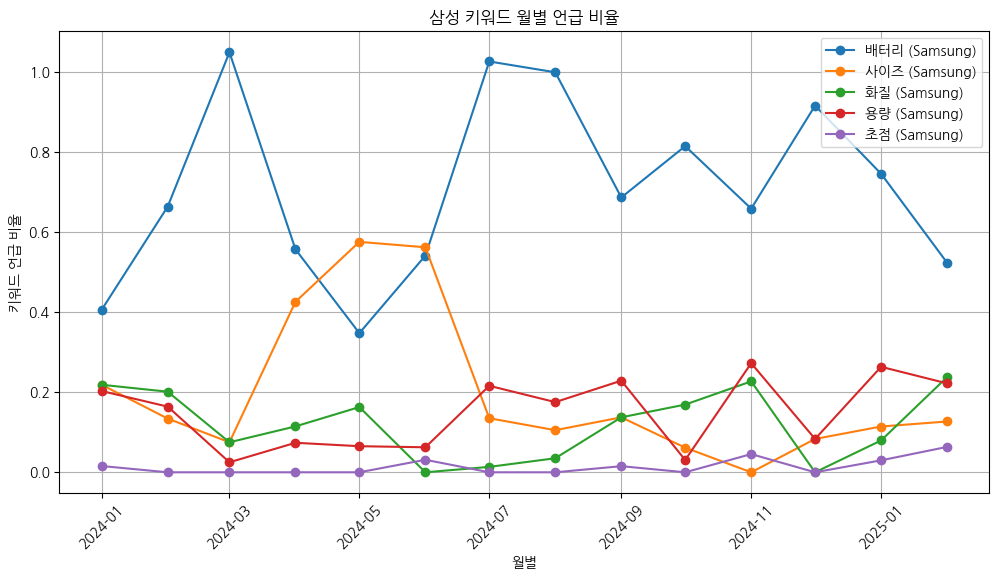

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for keyword in keyword_list:
    plt.plot(keyword_trend_df.index, keyword_trend_df[keyword], marker='o', label=f"{keyword} (Samsung)")

plt.title('삼성 키워드 월별 언급 비율')
plt.xlabel('월별')
plt.ylabel('키워드 언급 비율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [34]:
df_apple['comment_publish_date'] = pd.to_datetime(df_apple['comment_publish_date'])
df_apple['date_group'] = df_apple['comment_publish_date'].dt.to_period('M').dt.start_time

def keyword_filter(comment):
    return any(keyword in comment for keyword in keyword_list)

# 키워드가 포함된 댓글 필터링
filtered_df_apple = df_apple[df_apple['sentence'].apply(keyword_filter)].copy()
filtered_df_apple[['sentence', 'comment_publish_date']].head()

,sentence,comment_publish_date
110,아이폰 시리즈는 배터리가 항상 문제라 음,2024-10-17
131,아이폰시리즈는 다 좋은데 배터리 타임이 짧은게 제일 큰 단점 이였는데 47에서 61인치로 커지면서 배터리 용량도 늘어났으면 좋겠네요,2024-10-17
139,내년 아이폰 사라는 이야기는 매년 하는 소리고 솔직히 17이라고 크게 다를거 같지 않은데 뭐 슬림모델 나온다는건 그냥 새로운 라인인거고 일반 아이폰 라인에서 달라질게 있나 루머로는 뭐 페이스아이디 카메라가 디스플레이 밑으로 들어가니 마니 하는데 기껏 만들어놓은 다이나믹아일랜드 버리나 그리고 그렇게 되면 전면만 봐서는 갤럭시랑 분간이 안될건데 애플이 도약을 하려면 ai는 이미 늦었고 하드웨어로 뭘 어떻게 해야하는데 아예 전면 카메라도 디스플레이 밑에 넣는 수준 아니면 소비자들이 혹할만한 요소가 전혀 없을 듯 보나마나 a19 전작a16이나 a17이랑 비교하겠지대비 n 향상 배터리 타임 n시간 증가 이런 뻔하고 당연한 이야기만 할거고 예전엔 차 바꾸는 느낌이었는데 요즘은 컴퓨터 바꾸는 느낌임,2024-09-15
150,선예도 색감 2억화소라고 떠들더니 아이폰천만화소에 밀리는 삼성카메라 당연히 유튜브 동영상 시대 영상화질은 더욱아이폰에 발려 안쓰는거지 전면 셀카 카메라는 거의 안쓰고후면 카메라 쓰고 주변 사람들도 대부분 후면 카메라로 영상을 많이 찍는데삼성이 허접해 그리고 갤럭시를 아무리 접어도 카메라 성능이 막대 갤럭시보다 사양이 떨어져서 안산다모든 카메라 구입기준이 요즘은 카메라 동영상 사진을 기준으로 구입한다삼성이 살아남으려며 카메라 일본 케논 엔지니어들 영입하고 지금 카메라 개발팀 싹 교체해라나아지는게 없다,2024-09-28
152,선예도 색감 2억화소라고 떠들더니 아이폰천만화소에 밀리는 삼성카메라 당연히 유튜브 동영상 시대 영상화질은 더욱아이폰에 발려 안쓰는거지 전면 셀카 카메라는 거의 안쓰고후면 카메라 쓰고 주변 사람들도 대부분 후면 카메라로 영상을 많이 찍는데삼성이 허접해 그리고 갤럭시를 아무리 접어도 카메라 성능이 막대 갤럭시보다 사양이 떨어져서 안산다모든 카메라 구입기준이 요즘은 카메라 동영상 사진을 기준으로 구입한다삼성이 살아남으려며 카메라 일본 케논 엔지니어들 영입하고 지금 카메라 개발팀 싹 교체해라나아지는게 없다,2024-09-28


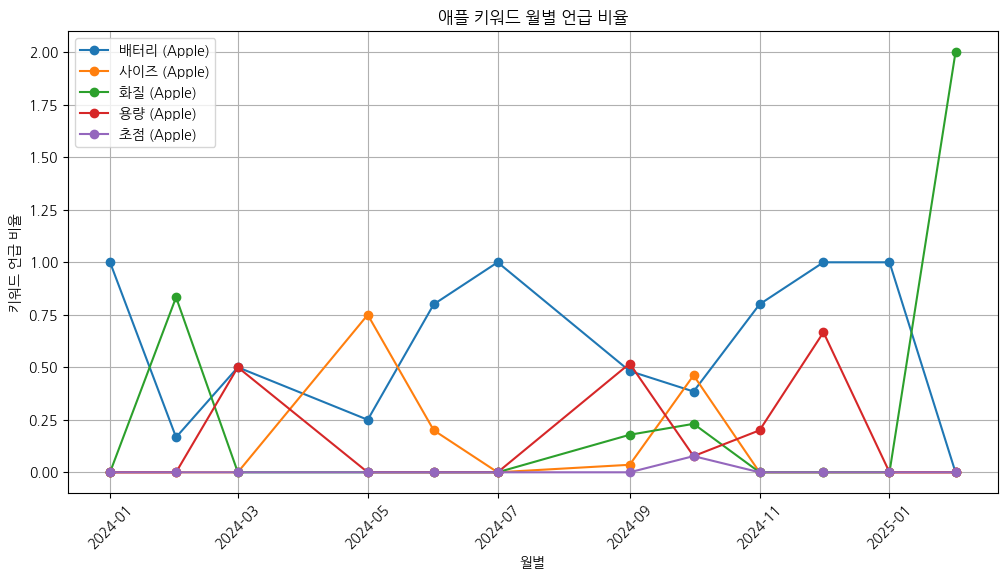

In [35]:
filtered_df_apple['comment_publish_date'] = pd.to_datetime(filtered_df_apple['comment_publish_date'])
filtered_df_apple['date_group'] = filtered_df_apple['comment_publish_date'].dt.to_period('M').dt.start_time
keyword_trend_apple = {}

# 월별로 그룹핑
for date, group in filtered_df_apple.groupby('date_group'):
    all_comments = ' '.join(group['sentence'])  # 월별 댓글 전부 합치기
    
    keyword_count = {}
    total_comments = len(group)  # 해당 월에 댓글 수
    for keyword in keyword_list:
        count = all_comments.count(keyword)  # 키워드 등장 횟수 세기
        keyword_count[keyword] = count / total_comments if total_comments != 0 else 0  # 비율 계산
    
    keyword_trend_apple[date] = keyword_count

keyword_trend_apple_df = pd.DataFrame(keyword_trend_apple).T.fillna(0)

keyword_trend_apple_df.head()
plt.figure(figsize=(12, 6))

for keyword in keyword_list:
    plt.plot(keyword_trend_apple_df.index, keyword_trend_apple_df[keyword], marker='o', label=f"{keyword} (Apple)")

plt.title('애플 키워드 월별 언급 비율')
plt.xlabel('월별')
plt.ylabel('키워드 언급 비율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

## 키워드 감성 라벨 수 트렌드 분석

In [17]:
for keyword in keyword_list:
    filtered_df[keyword] = filtered_df['sentence'].apply(lambda x: keyword in x)

melt_df = filtered_df.melt(
    id_vars=['date_group', 'samsung_sentiment'],  # 유지할 컬럼
    value_vars=keyword_list,                      # 키워드 컬럼
    var_name='keyword',                           # 키워드 이름
    value_name='is_present'                       # 포함 여부 True/False
)

melt_df = melt_df[melt_df['is_present'] == True]
melt_df.head()

,date_group,samsung_sentiment,keyword,is_present
0,2025-02-01,1,배터리,True
3,2025-01-01,1,배터리,True
4,2024-07-01,0,배터리,True
5,2025-01-01,0,배터리,True
10,2025-01-01,0,배터리,True


In [18]:
grouped_df = melt_df.groupby(['date_group', 'keyword', 'samsung_sentiment']).size().reset_index(name='count')
grouped_df.head()

,date_group,keyword,samsung_sentiment,count
0,2024-01-01,배터리,0,17
1,2024-01-01,배터리,1,8
2,2024-01-01,사이즈,0,6
3,2024-01-01,사이즈,1,7
4,2024-01-01,용량,0,10


In [19]:
pivot_df = grouped_df.pivot_table(
    index=['date_group', 'keyword'],
    columns='samsung_sentiment',
    values='count',
    fill_value=0
).reset_index()

pivot_df.columns = ['date_group', 'keyword', 'negative_count', 'positive_count']
pivot_df.head()

,date_group,keyword,negative_count,positive_count
0,2024-01-01,배터리,17,8
1,2024-01-01,사이즈,6,7
2,2024-01-01,용량,10,3
3,2024-01-01,초점,0,1
4,2024-01-01,화질,7,7


In [60]:
# 긍정 + 부정 전체 합 구하기
pivot_df['total'] = pivot_df['positive_count'] + pivot_df['negative_count']

# 비율 계산
pivot_df['positive_ratio'] = pivot_df['positive_count'] / pivot_df['total']
pivot_df['negative_ratio'] = pivot_df['negative_count'] / pivot_df['total']

# 0으로 나눌 경우 대비해서 처리하고 싶으면 이렇게!
pivot_df['positive_ratio'] = pivot_df.apply(lambda x: x['positive_count'] / x['total'] if x['total'] > 0 else 0, axis=1)
pivot_df['negative_ratio'] = pivot_df.apply(lambda x: x['negative_count'] / x['total'] if x['total'] > 0 else 0, axis=1)

pivot_df.head()

,date_group,keyword,negative_count,positive_count,total,positive_ratio,negative_ratio
0,2024-01-01,배터리,17,8,25,0.320000,0.680000
1,2024-01-01,사이즈,6,7,13,0.538462,0.461538
2,2024-01-01,용량,10,3,13,0.230769,0.769231
3,2024-01-01,초점,0,1,1,1.000000,0.000000
4,2024-01-01,화질,7,7,14,0.500000,0.500000


In [66]:
import plotly.graph_objects as go

# 날짜와 키워드 추출
dates = pivot_df['date_group'].unique()
keywords = pivot_df['keyword'].unique()

# 프레임 만들기
frames = []
for date in dates:
    df_date = pivot_df[pivot_df['date_group'] == date]

    # 각 date 별로 긍정/부정 비율 추출
    긍정비율 = df_date['positive_ratio'].tolist()
    부정비율 = df_date['negative_ratio'].tolist()

    # 프레임에 긍정/부정 각각 추가
    frames.append(go.Frame(
        data=[
            go.Bar(name='긍정', x=keywords, y=긍정비율, marker_color='lightblue'),
            go.Bar(name='부정', x=keywords, y=부정비율, marker_color='salmon')
        ],
        name=str(date)[:10]  # 날짜 문자열 포맷 맞추기
    ))

# 초기값 (첫번째 날짜로)
df_first = pivot_df[pivot_df['date_group'] == dates[0]]
긍정비율 = df_first['positive_ratio'].tolist()
부정비율 = df_first['negative_ratio'].tolist()

# figure 생성
fig = go.Figure(
    data=[
        go.Bar(name='긍정', x=keywords, y=긍정비율, marker_color='lightblue'),
        go.Bar(name='부정', x=keywords, y=부정비율, marker_color='salmon')
    ],
    layout=go.Layout(
        title="키워드별 긍/부정 비율 (시간 슬라이더)",
        barmode='stack',
        xaxis_title='키워드',
        yaxis_title='비율',
        yaxis=dict(range=[0, 1]),  # 비율이니까 0~1
        updatemenus=[{
            'type': 'buttons',
            'showactive': False,
            'buttons': [{
                'label': '재생',
                'method': 'animate',
                'args': [None, {'frame': {'duration': 1000, 'redraw': True}, 'fromcurrent': True}]
            }]
        }]
    ),
    frames=frames
)

# 슬라이더 추가
fig.update_layout(
    sliders=[{
        'steps': [{
            'args': [[str(date)[:10]], {'frame': {'duration': 500, 'redraw': True}, 'mode': 'immediate'}],
            'label': str(date)[:10],
            'method': 'animate'
        } for date in dates],
        'transition': {'duration': 300},
        'x': 0.1,
        'y': -0.15,
        'currentvalue': {'prefix': '날짜: ', 'visible': True, 'xanchor': 'right'}
    }]
)

fig.show()


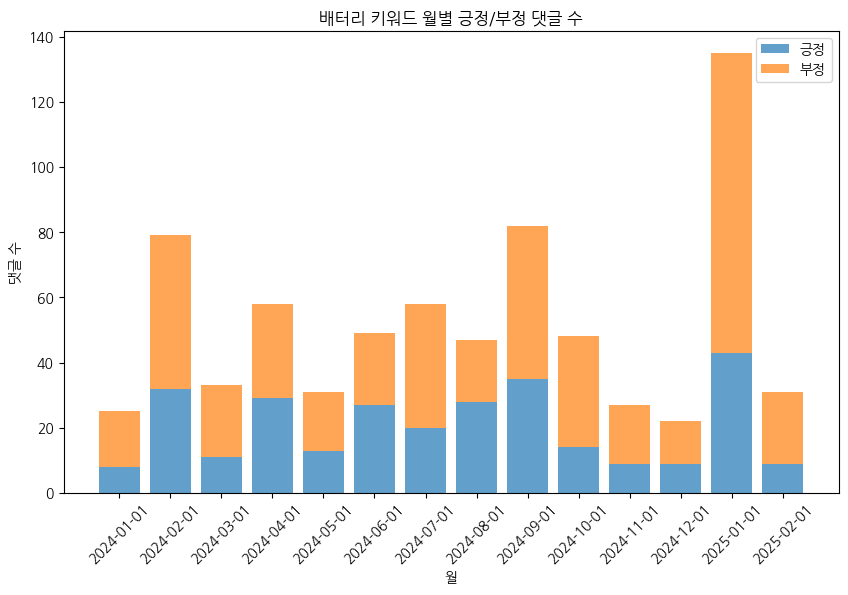

In [20]:
keyword = '배터리'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))
plt.bar(data['date_group'].astype(str), data['positive_count'], label='긍정', alpha=0.7)
plt.bar(data['date_group'].astype(str), data['negative_count'], bottom=data['positive_count'], label='부정', alpha=0.7)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.xticks(rotation=45)
plt.show()

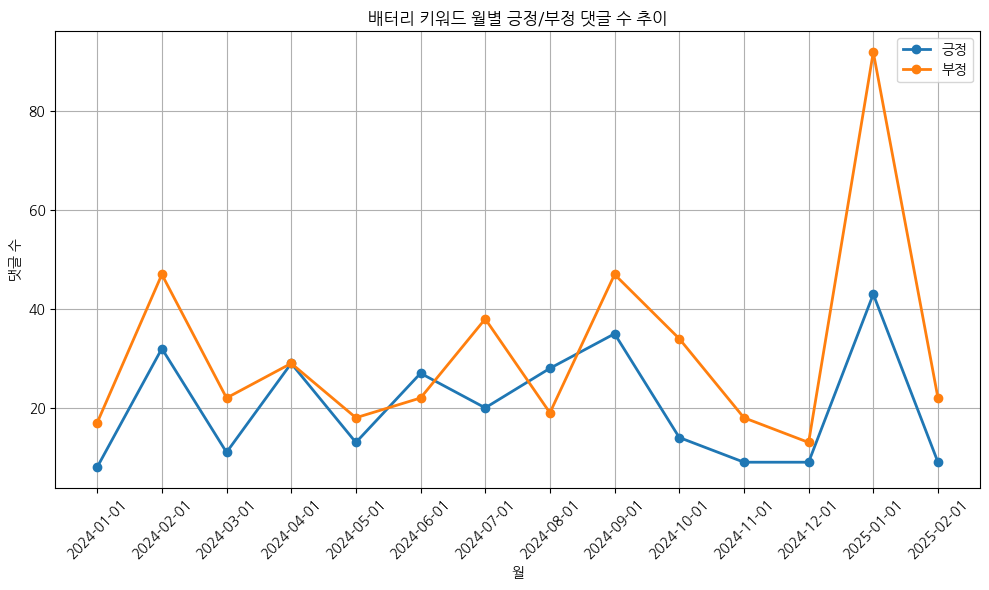

In [21]:
keyword = '배터리'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# 긍정 라인
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='긍정', linewidth=2)

# 부정 라인
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='부정', linewidth=2)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수 추이')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


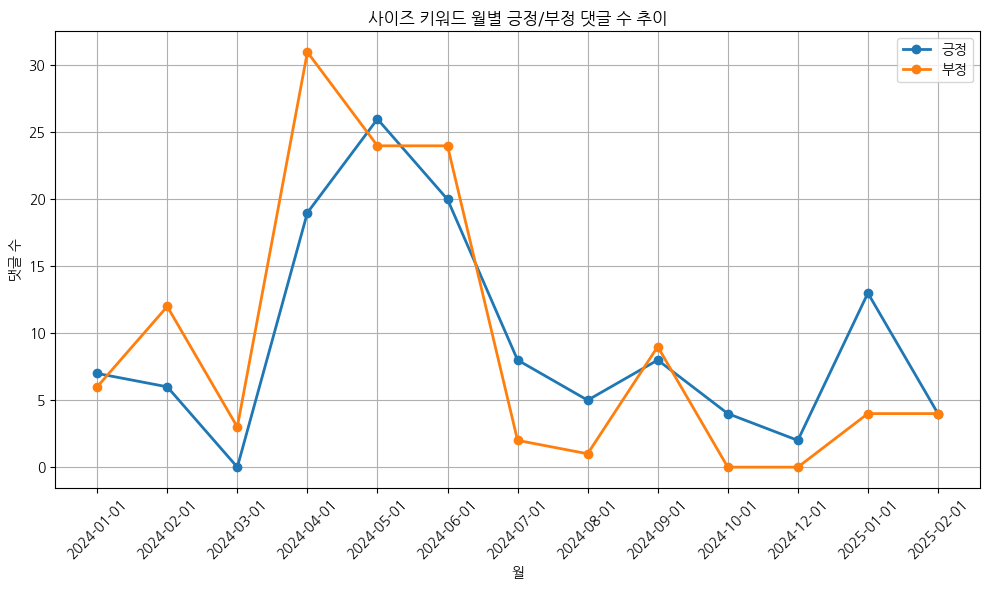

In [25]:
keyword = '사이즈'
data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# 긍정 라인
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='긍정', linewidth=2)

# 부정 라인
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='부정', linewidth=2)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수 추이')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


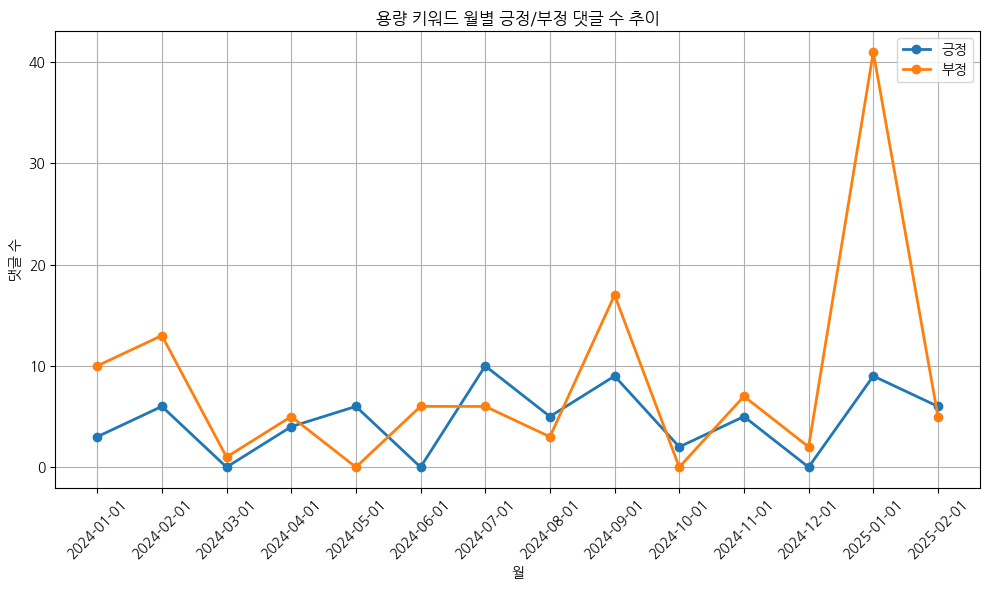

In [26]:
keyword = '용량'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# 긍정 라인
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='긍정', linewidth=2)

# 부정 라인
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='부정', linewidth=2)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수 추이')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


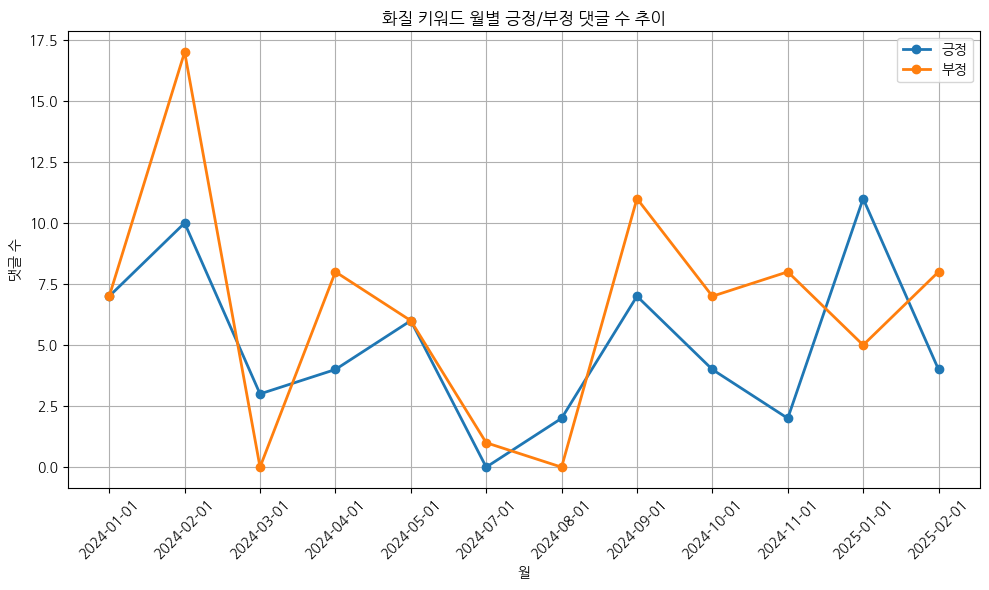

In [27]:
keyword = '화질'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# 긍정 라인
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='긍정', linewidth=2)

# 부정 라인
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='부정', linewidth=2)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수 추이')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

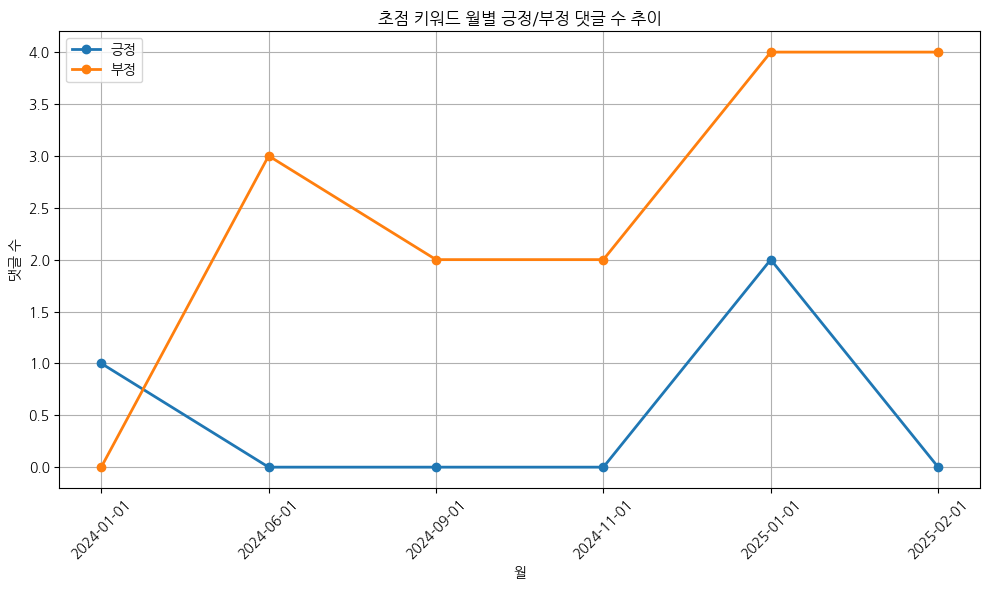

In [28]:
keyword = '초점'

data = pivot_df[pivot_df['keyword'] == keyword]

plt.figure(figsize=(10, 6))

# 긍정 라인
plt.plot(data['date_group'].astype(str), data['positive_count'], marker='o', label='긍정', linewidth=2)

# 부정 라인
plt.plot(data['date_group'].astype(str), data['negative_count'], marker='o', label='부정', linewidth=2)

plt.title(f'{keyword} 키워드 월별 긍정/부정 댓글 수 추이')
plt.xlabel('월')
plt.ylabel('댓글 수')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 연관어 분석

In [50]:
def extract_nouns(df, text_column='sentence'):
    okt = Okt()
    df['noun'] = df[text_column].apply(lambda x: " ".join(okt.nouns(x)))
    return df
df_apple = extract_nouns(df_apple)
df_samsung = extract_nouns(df_samsung)
df_apple.head(), df_samsung.head()

(      video_id                                             title publish_date  \
 0  JEnFUkGHN5E         애타게 기다렸다.. 삼성 ‘정상화’. 갤럭시 S25 시리즈 달라진 9가지!   2025-01-25   
 1  sDWeyVdXQwY  새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.   2024-01-17   
 2  sDWeyVdXQwY  새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.   2024-01-17   
 3  sDWeyVdXQwY  새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.   2024-01-17   
 4  sDWeyVdXQwY  새로운 삼성 갤럭시 S24/S24+/S24 울트라 첫 인상! 아이폰같은데 예뻐졌습니다.   2024-01-17   
 
   channel_name  \
 0      ITSub잇섭   
 1      ITSub잇섭   
 2      ITSub잇섭   
 3      ITSub잇섭   
 4      ITSub잇섭   
 
                                                                                                                                                                                                                                                                                                                                                                                                      

In [51]:
tmp = df_apple[df_apple['sentence'].str.contains(r'사진 촬영|사진|촬영', regex=True)]
tmp.shape

(116, 15)

In [94]:
stop_words_list = ['가면', '갈수록', '갑임', '개인', '갤럭시', '거의', '고민', '구려', '그냥', '극단', '극우',
 '기능', '기본', '기준', '다시', '대부분', '대해', '더욱', '때문', '망작', '맥스', '무리',
 '문제', '물씬', '바로', '방법', '별로', '보고', '부분', '비교', '사람', '사용', '삼성',
 '생각', '설명', '순간', '시리즈', '아이폰', '아주', '압승', '애초', '애플', '엘지',
 '울트라', '원래', '은색', '이번', '이상', '이유', '이제', '일반', '일이', '정도',
 '정말', '제품', '주변', '지금', '짝퉁', '차이', '처리', '카메라', '커서', '특유',
 '패스', '프로', '프맥', '플러스', '플립', '항상', '혹시']

In [54]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list)
tfidf_matrix = vectorizer.fit_transform(tmp["noun"])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
tfidf_dict = dict(zip(feature_names, tfidf_scores))
top_nouns = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_nouns)

[('영상', 5.6547307707803025), ('사용', 5.4583427077149524), ('동영상', 3.6015855171101325), ('용량', 3.5245914816613766), ('인물사진', 3.2698286616814443), ('색감', 3.07878482891107), ('업데이트', 2.966300468066748), ('느낌', 2.8018922805643167), ('접사', 2.754005110583237), ('화질', 2.6730306984445527), ('삼성', 2.5676697872260323), ('극단', 2.514875436251691), ('매장', 2.514875436251691), ('핸드폰', 2.514875436251691), ('추천', 2.491823652274639), ('기능', 2.3035232255535116), ('야간', 1.9591771562128175), ('개인', 1.958206459351894), ('셀카', 1.9326652578587051), ('개선', 1.866162847995238)]


In [55]:
tmp2 = df_samsung[df_samsung['sentence'].str.contains(r'사진 촬영|사진|촬영', regex=True)]
tmp2.shape

(577, 15)

In [66]:
vectorizer = TfidfVectorizer(stop_words=stop_words_list)
tfidf_matrix = vectorizer.fit_transform(tmp2["noun"])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)
tfidf_dict = dict(zip(feature_names, tfidf_scores))
top_nouns = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_nouns)

[('영상', 22.005970456415884), ('울트라', 19.21509411604676), ('동영상', 11.840593060136651), ('색감', 11.391747342107635), ('보정', 10.758315029312685), ('버튼', 8.605726475760619), ('화질', 8.355406646712492), ('편집', 7.904892401785345), ('콘서트', 6.301976862281329), ('느낌', 6.074741375996745), ('야간', 5.95647573607983), ('배줌', 5.917100571810207), ('블루투스', 5.6583915651326935), ('확대', 5.647273743076798), ('얼굴', 5.43804299419482), ('인물사진', 5.177936813670379), ('가격', 4.992947324884646), ('망원', 4.931561151793162), ('음식', 4.910155497041279), ('로그', 4.77953261564215)]


In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(stop_words=stop_words_list)
count_matrix = vectorizer.fit_transform(tmp2["noun"]) 
cosine_sim = cosine_similarity(count_matrix, count_matrix)

feature_names = vectorizer.get_feature_names_out()
word_freq = count_matrix.toarray().sum(axis=0) 
word_freq_dict = dict(zip(feature_names, word_freq))
top_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)[:20]
print(top_words)

[('영상', 75), ('울트라', 55), ('동영상', 36), ('버튼', 34), ('색감', 26), ('보정', 25), ('화질', 25), ('편집', 22), ('느낌', 20), ('배줌', 18), ('음식', 18), ('가격', 17), ('배터리', 14), ('설정', 14), ('용량', 14), ('화면', 14), ('디자인', 13), ('인물사진', 13), ('콘서트', 13), ('블루투스', 12)]


In [92]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 동시 출현 행렬
def co_occurrence_matrix(corpus):
    vectorizer = CountVectorizer(stop_words=stop_words_list, binary=True)
    X = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names_out()
    cooc = X.T @ X  
    return cooc, words

# 동시 출현 빈도 계산
cooc, features = co_occurrence_matrix(tmp2["noun"])
cooc_df = pd.DataFrame(cooc.toarray(), 
                      index=features, 
                      columns=features)

# 상위 20개 단어 추출 
word_cooccur = cooc_df.sum(axis=1).sub(cooc_df.values.diagonal())  
top_cooccur_words = word_cooccur.sort_values(ascending=False).head(20)

print("동시 출현 기반 상위 20개 단어:")
print(top_cooccur_words.reset_index().values.tolist())

동시 출현 기반 상위 20개 단어:
[['영상', 334], ['동영상', 217], ['화질', 156], ['편집', 139], ['디자인', 138], ['휴대폰', 136], ['공간', 126], ['느낌', 121], ['가격', 119], ['메모리', 117], ['색감', 116], ['번역', 111], ['어플', 100], ['용량', 98], ['외국', 97], ['화면', 96], ['전화', 95], ['문자', 95], ['스마트폰', 89], ['국제', 88]]


In [95]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 동시 출현 빈도 계산
cooc, features = co_occurrence_matrix(tmp["noun"])
cooc_df = pd.DataFrame(cooc.toarray(), 
                      index=features, 
                      columns=features)

# 상위 20개 단어 추출 
word_cooccur = cooc_df.sum(axis=1) - cooc_df.values.diagonal()  
top_cooccur_words = word_cooccur.sort_values(ascending=False).head(20)

print("동시 출현 기반 상위 20개 단어:")
print(top_cooccur_words.reset_index().values.tolist())

동시 출현 기반 상위 20개 단어:
[['동영상', 241], ['영상', 216], ['성능', 182], ['화질', 167], ['색감', 164], ['느낌', 153], ['셀카', 133], ['화소', 110], ['시대', 110], ['요즘', 104], ['개선', 99], ['전면', 97], ['차이점', 96], ['구입', 92], ['교체', 92], ['사양', 92], ['고후', 92], ['다모', 92], ['버튼', 92], ['안산', 92]]


## 키워드 빈도 분석

In [81]:
# 키워드 빈도 계산
def get_keyword_counts(df, keyword_list):
    keyword_counts = Counter()
    for sentence in df["sentence"]:  
        for keyword in keyword_list:
            if keyword in sentence:
                keyword_counts[keyword] += 1
    return keyword_counts

In [82]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [83]:
import plotly.express as px

apple_counts = get_keyword_counts(df_apple, keyword_list)
samsung_counts = get_keyword_counts(df_samsung, keyword_list)

def plot_stacked_bar_chart(apple_counts, samsung_counts):
    df = pd.DataFrame([
        {"keyword": key, "count": apple_counts[key], "brand": "애플"} for key in apple_counts
    ] + [
        {"keyword": key, "count": samsung_counts[key], "brand": "삼성"} for key in samsung_counts
    ])
    
    df = df.sort_values(by='count', ascending=True)
    color_map = {
        "애플": "#FF9999",  
        "삼성": "#66B2FF"  
    }

    fig = px.bar(df, x="keyword", y="count", color="brand", 
                 title="삼성 vs 애플 키워드 언급량",
                 barmode="group",   # 'group' or 'stack'
                 color_discrete_map=color_map) 
    fig.update_layout(
        plot_bgcolor="#F5F5F5",   # 그래프 내부 배경 (연한 회색)
        paper_bgcolor="#F5F5F5",  # 전체 배경 (어두운 회색)
        font=dict(color="black")  # 폰트 색상
    )
    
    fig.show(config={'displayModeBar': True})

plot_stacked_bar_chart(apple_counts, samsung_counts)

In [87]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np

# 네트워크 그래프 생성
G = nx.Graph()

# 중심 노드 추가 (고정 크기)
center_word = "사진 촬영"
G.add_node(center_word, size=200, color="#FF9999")

# 주변 단어 추가 (TF-IDF 상위 20개 단어)
for word, score in top_nouns:
    min_size = 50
    max_size= 150
    node_size = max(min_size, min(score * 3, max_size)) # TF-IDF 점수에 따른 크기 조정
    G.add_node(word, size=node_size)
    G.add_edge(center_word, word, weight=score)

# 네트워크 레이아웃 설정 (중심 단어 고정)
pos = nx.spring_layout(G, seed=42, k=1) # k가 클수록 노드들이 멀리 퍼짐
pos[center_word] = np.array([0, 0])  # 중심 노드를 (0,0)으로 고정

# 좌표 정규화 (너무 커지는 걸 방지)
scale_factor = 1.5  
for key in pos:
    pos[key] = np.array(pos[key]) * scale_factor

# 엣지(Edges) 추가
edge_x = []
edge_y = []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)  # 선 분리
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1.5, color="gray"),
    hoverinfo="none",
    mode="lines"
)

# 노드(Nodes) 추가
node_x = []
node_y = []
node_size = []
node_color = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_size.append(G.nodes[node]["size"])  # 동적으로 계산된 크기 적용
    node_color.append("#FF9999" if node == center_word else "#66B2FF")
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers+text",
    text=node_text,  # 텍스트 추가
    textposition="middle center",  # 동그라미 안에 글자 배치
    hoverinfo="text",
    marker=dict(
        size=node_size,  # 크기 동적으로 반영
        color=node_color,
        line=dict(width=0)
    ),
    textfont=dict(
        size=10,  # 글자 크기 조절
        color="black"  
    )
)

# 레이아웃 설정 및 그래프 출력
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="사진 촬영 연관어 분석",
    showlegend=False,
    hovermode="closest",
    margin=dict(b=50, l=50, r=50, t=50),  # 마진 조정
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    width=800,
    height=800
)

fig.show()

## 감성 분석

In [6]:
samsung_df = pd.read_csv('final_samsung_df.csv')
apple_df = pd.read_csv('final_apple_df.csv')
samsung_df.shape, apple_df.shape

((32964, 14), (2426, 14))

In [9]:
samsung_df[['sentence', 'samsung_sentiment', 'samsung_score']].head(5)

,sentence,samsung_sentiment,samsung_score
0,갤럭시는뭐 매년상승되는 기본상승력인 스냅말고없음,0,0.978018
1,갤럭시 도 쓸만함,1,0.929495
2,아니 빅스비에서 되던건 되게 해줘야지요,0,0.863897
3,전 겔럭시 갤럭시 갤럭시 유저인데 갤럭시울트라는 반도체와 각종 부품을 중국산을 쓰니 쌰오미와 비슷해진듯 우리의 삼성 어디,0,0.786425
4,이젠 갤럭시이 아이폰보다 더 예뻐보인다,1,0.955561


In [8]:
# 삼성에서 키워드 포함된 문장만 필터링
samsung_filtered = samsung_df[samsung_df['sentence'].str.contains('|'.join(keyword_list), regex=True)].copy()

# 애플에서 키워드 포함된 문장만 필터링
apple_filtered = apple_df[apple_df['sentence'].str.contains('|'.join(keyword_list), regex=True)].copy()

samsung_sentiment_count = samsung_filtered['samsung_sentiment'].value_counts()
apple_sentiment_count = apple_filtered['apple_sentiment'].value_counts()
print(samsung_sentiment_count)
print(apple_sentiment_count)

samsung_sentiment
0    707
1    500
Name: count, dtype: int64
apple_sentiment
0    61
1    54
Name: count, dtype: int64


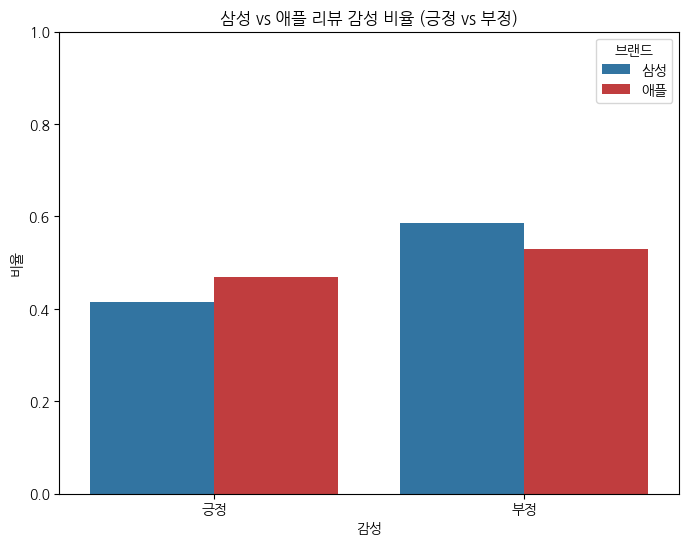

In [22]:
# 비율 계산
samsung_total = samsung_sentiment_count.sum()
apple_total = apple_sentiment_count.sum()

samsung_pos_ratio = samsung_sentiment_count[1] / samsung_total
samsung_neg_ratio = samsung_sentiment_count[0] / samsung_total

apple_pos_ratio = apple_sentiment_count[1] / apple_total
apple_neg_ratio = apple_sentiment_count[0] / apple_total

df_ratio = pd.DataFrame({
    '브랜드': ['삼성', '삼성', '애플', '애플'],
    '감성': ['긍정', '부정', '긍정', '부정'],
    '비율': [samsung_pos_ratio, samsung_neg_ratio, apple_pos_ratio, apple_neg_ratio]
})

# 시각화
plt.figure(figsize=(8, 6))

sns.barplot(
    data=df_ratio,
    x='감성',
    y='비율',
    hue='브랜드',
    palette={'삼성': '#1f77b4', '애플': '#d62728'}
)

plt.title('삼성 vs 애플 리뷰 감성 비율 (긍정 vs 부정)')
plt.ylim(0, 1)
plt.xlabel('감성')
plt.legend(title='브랜드')
plt.show()

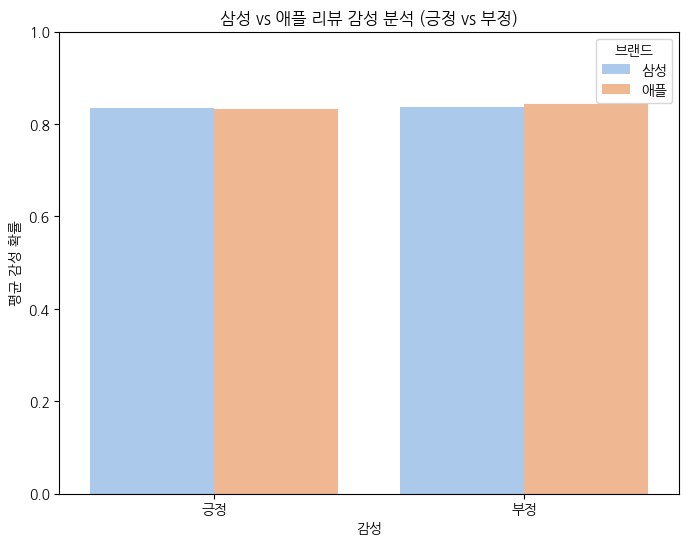

In [19]:
# 삼성 긍정/부정 점수 평균 계산
samsung_pos_score = samsung_filtered[samsung_filtered['samsung_sentiment'] == 1]['samsung_score']
samsung_neg_score = samsung_filtered[samsung_filtered['samsung_sentiment'] == 0]['samsung_score']

samsung_pos_mean = samsung_pos_score.mean()
samsung_neg_mean = samsung_neg_score.mean()

# 애플 긍정/부정 점수 평균 계산
apple_pos_score = apple_filtered[apple_filtered['apple_sentiment'] == 1]['apple_score']
apple_neg_score = apple_filtered[apple_filtered['apple_sentiment'] == 0]['apple_score']

apple_pos_mean = apple_pos_score.mean()
apple_neg_mean = apple_neg_score.mean()

# 데이터프레임으로 변환해서 seaborn에 넘기기
df_sentiment = pd.DataFrame({
    '브랜드': ['삼성', '삼성', '애플', '애플'],
    '감성': ['긍정', '부정', '긍정', '부정'],
    '평균 확률': [samsung_pos_mean, samsung_neg_mean, apple_pos_mean, apple_neg_mean]
})

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=df_sentiment, x='감성', y='평균 확률', hue='브랜드', palette='pastel')

plt.title('삼성 vs 애플 리뷰 감성 분석 (긍정 vs 부정)')
plt.ylim(0, 1)
plt.ylabel('평균 감성 확률')
plt.xlabel('감성')
plt.legend(title='브랜드')
plt.show()

In [174]:
df_apple[df_apple['sentence'].str.contains('초점')]

,video_id,title,publish_date,channel_name,comment,like_count,comment_publish_date,load_date,cleaned_comment,normalized_comment,sentence,predicted_brand,apple_sentiment,apple_score,noun
1819,gpoYYQftWhQ,옛날 아이폰 싹다 파묘해왔습니다! 그런데 사진이 더 예쁘게 나온다..? [구형 스마트폰 리뷰],2024-09-16,주연 ZUYONI,아이폰 최대 단점은 카메라 먹통 ㅡ 랜즈깨짐 ㅡ초첨불량ㅡ 또 플래스십 아래 모댈은 랜즈초점거리 단순하고 화질 구림 ㅡ 갤럭시는 디자인구리지만 아이폰은 이전화면 또는 화면전환이 무쟈게 불편하고 글자입력시 이래도 되나싶게 커서가 안먹음 ㅡㅡㅡㅡ앱지원도 안해줌 소통불량,0,2024-10-04,2025-02-27 21:00:02,아이폰 최대 단점은 카메라 먹통 랜즈깨짐 초첨불량 또 플래스십 아래 모댈은 랜즈초점거리 단순하고 화질 구림 갤럭시는 디자인구리지만 아이폰은 이전화면 또는 화면전환이 무쟈게 불편하고 글자입력시 이래도 되나싶게 커서가 안먹음 앱지원도 안해줌 소통불량,아이폰 최대 단점은 카메라 먹통 랜즈깨짐 초첨불량 또 플래스십 아래 모댈은 랜즈초점거리 단순하고 화질 구림 갤럭시는 디자인구리지만 아이폰은 이전화면 또는 화면전환이 무쟈게 불편하고 글자입력시 이래도 되나싶게 커서가 안먹음 앱지원도 안해줌 소통불량,초첨불량 또 플래스십 아래 모댈은 랜즈초점거리 단순하고 화질 구림 갤럭시는 디자인구리지만 아이폰은 이전화면 또는 화면전환이 무쟈게 불편하고 글자입력시 이래도 되나싶게 커서가 안먹음,apple,0,0.997901,초 불량 또 플래스십 아래 모 랜 초점거리 화질 구림 갤럭시 디자인 구리 아이폰 이전 화면 화면 전환 무쟈 글자 입력 시 커서


In [120]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [175]:
keyword_sentiment_scores = {}

# 각 키워드별 감성 점수 계산
for keyword in keyword_list:
    # 키워드 포함된 문장 필터링 (삼성)
    samsung_subset = df_samsung[df_samsung['sentence'].str.contains(keyword, regex=True)]
    apple_subset = df_apple[df_apple['sentence'].str.contains(keyword, regex=True)]
    
    # 삼성 긍정 & 부정 감성 점수 평균
    positive_samsung = samsung_subset[samsung_subset['samsung_sentiment'] == '1']['samsung_score'].mean()
    negative_samsung = samsung_subset[samsung_subset['samsung_sentiment'] == '0']['samsung_score'].mean()

    # 애플 긍정 & 부정 감성 점수 평균
    positive_apple = apple_subset[apple_subset['apple_sentiment'] == '1']['apple_score'].mean()
    negative_apple = apple_subset[apple_subset['apple_sentiment'] == '0']['apple_score'].mean()

    # 저장
    keyword_sentiment_scores[keyword] = {
        '삼성 긍정': positive_samsung,
        '삼성 부정': negative_samsung,
        '애플 긍정': positive_apple,
        '애플 부정': negative_apple
    }

df_keyword_sentiment = pd.DataFrame(keyword_sentiment_scores).T
df_keyword_sentiment.fillna(0, inplace=True)

In [176]:
df_keyword_sentiment

,삼성 긍정,삼성 부정,애플 긍정,애플 부정
배터리,0.849542,0.845319,0.877452,0.806116
사이즈,0.804833,0.768287,0.820657,0.803706
화질,0.803417,0.859016,0.810564,0.912505
용량,0.871430,0.840992,0.827852,0.893778
초점,0.743679,0.890293,0.000000,0.997901


<Figure size 1200x600 with 0 Axes>

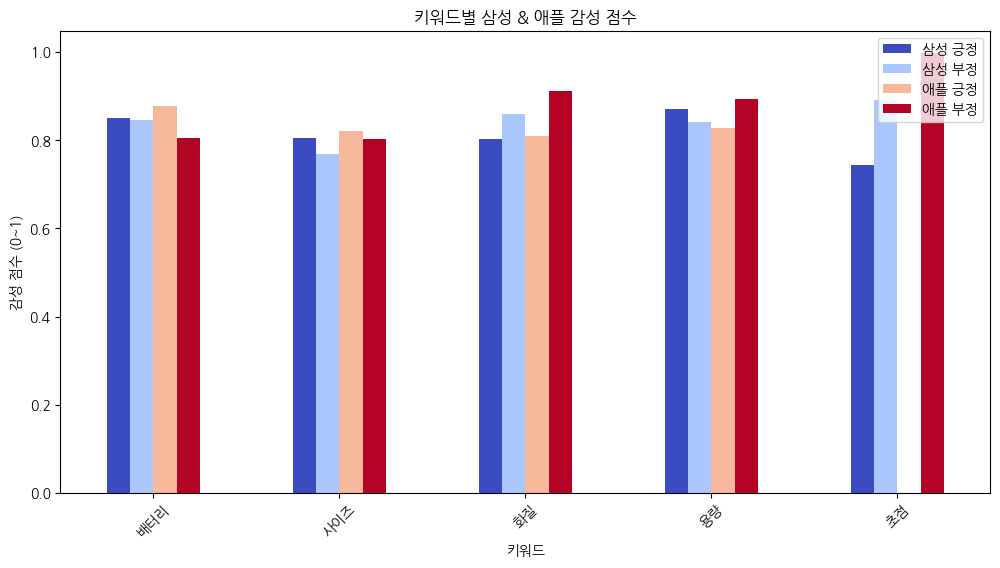

In [177]:
plt.figure(figsize=(12, 6))
df_keyword_sentiment.plot(kind='bar', colormap='coolwarm', figsize=(12, 6))
plt.title("키워드별 삼성 & 애플 감성 점수")
plt.xlabel("키워드")
plt.ylabel("감성 점수 (0~1)")
plt.xticks(rotation=45)  
plt.legend(loc="upper right")
plt.show()

In [178]:
import plotly.graph_objects as go
import plotly.subplots as sp

num_keywords = len(df_keyword_sentiment)
fig = sp.make_subplots(rows=2, cols=num_keywords, 
                       subplot_titles=[f"{keyword}" for keyword in df_keyword_sentiment.index],
                       specs=[[{"type": "indicator"}] * num_keywords] * 2)

for i, (keyword, scores) in enumerate(df_keyword_sentiment.iterrows()):
    # 삼성 긍정 감성
    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=scores['삼성 긍정'] * 100,  
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "black"},
            'steps': [
                {'range': [0, 33], 'color': "#D6E4F0"},
                {'range': [33, 66], 'color': "#A9C1D9"},
                {'range': [66, 100], 'color': "#5078A0"}
            ]
        }
    ), row=1, col=i+1)

    # 애플 긍정 감성
    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=scores['애플 긍정'] * 100, 
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "black"},
            'steps': [
                {'range': [0, 33], 'color': "#D6E4F0"},
                {'range': [33, 66], 'color': "#A9C1D9"},
                {'range': [66, 100], 'color': "#5078A0"}
            ]
        }
    ), row=2, col=i+1)

fig.update_layout(title_text="키워드별 감성 분석 (삼성 & 애플)")
fig.show()